# CERN Electron Collision Data
## (Particle collision events with two electrons)

#### Context
This dataset contains 100k dielectron events in the invariant mass range 2-110 GeV for use in outreach and education. These data were selected for use in education and outreach and contain a subset of the total event information. The selection criteria may be different from that used in CMS physics results.

#### Content
- 1) Run: The run number of the event. 
- 2) Event: The event number. 
- 3,11) E1, E2: The total energy of the electron (GeV) for electrons 1 and 2. 
- 4, 5, 6, 12, 13, 14) px1,py1,pz1,px2,py2,pz2: The components of the momemtum of the electron 1 and 2 (GeV). 
- 7, 15) pt1, pt2: The transverse momentum of the electron 1 and 2 (GeV). 8, 16) eta1, eta2: The pseudorapidity of the electron 1 and 2. 
- 9, 17) phi1, phi2: The phi angle of the electron 1 and 2 (rad). 
- 10, 18) Q1, Q2: The charge of the electron 1 and 2. 
- 19) M: The invariant mass of two electrons (GeV).


# 1. Import required dependencies

In [145]:
#For data manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

#For model building
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse 
import xgboost
from xgboost import XGBRegressor

In [146]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cern-electron-collision-data/dielectron.csv


## 2. Load the dataset

In [147]:
#Let us see the contents of the dataset
data = pd.read_csv("/kaggle/input/cern-electron-collision-data/dielectron.csv")
data.head()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


## 3. Data Cleaning

In [148]:
#Let's now check if there are any null values in the dataset
data.isnull().sum()

Run       0
Event     0
E1        0
px1       0
py1       0
pz1       0
pt1       0
eta1      0
phi1      0
Q1        0
E2        0
px2       0
py2       0
pz2       0
pt2       0
eta2      0
phi2      0
Q2        0
M        85
dtype: int64

#### As we can infer there are 85 missing values in the invariant mass M column, let us now start the data cleaning process

In [149]:
print(f"Shape of M before data cleaning with null values: {data.M.shape}")
#There are 100000 events out of which there are 85 missing values, which is negligible. Thus, we can drop these missing M values
data = data.dropna()
data.isnull().sum()
print(f"Shape of M after data cleaning without null values: {data.M.shape}")

Shape of M before data cleaning with null values: (100000,)
Shape of M after data cleaning without null values: (99915,)


In [150]:
data.Event.value_counts()

Event
440012942    3
439950319    3
519135297    2
337473110    2
337851094    2
            ..
533379552    1
532994296    1
533628462    1
527669805    1
524172389    1
Name: count, Length: 99891, dtype: int64

#### Here we can see that there are certain events recorded more than once, So, we need to drop these duplicates

In [151]:
data =  data.drop_duplicates(['Event'])
data.Event.value_counts()
data.shape

(99891, 19)

### Let's now see the distribution of invariant mass of dielectron (GeV) 

Text(0.5, 1.0, 'Distribution of M - Invariant mass of dielectron (GeV)')

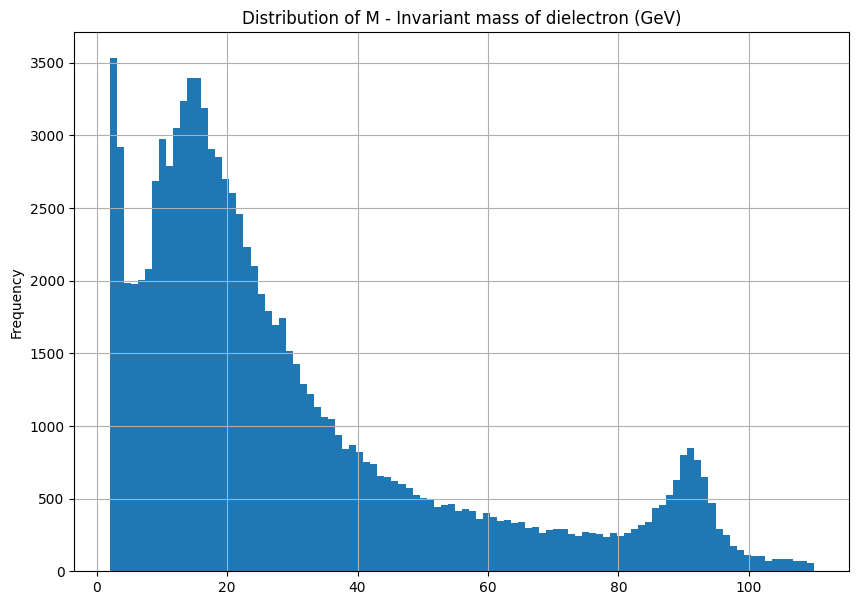

In [152]:
plt.figure(figsize=(10,7))
# plt.hist(data.M, bins=100)
data.M.plot(kind='hist',bins=100)
plt.grid()
plt.title("Distribution of M - Invariant mass of dielectron (GeV)")

**Let's now see the correlation among the features**

<Axes: >

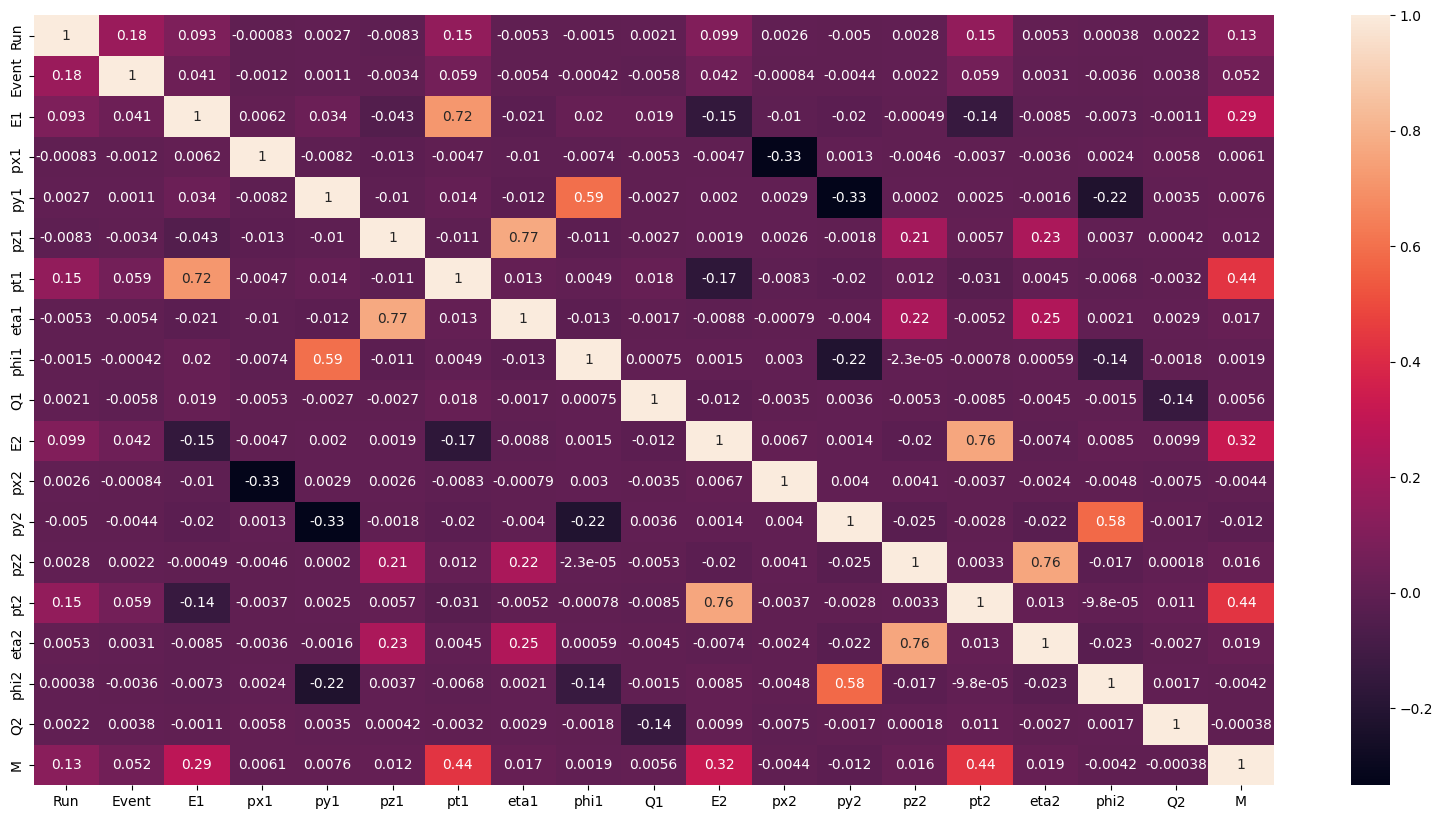

In [153]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), annot=True)

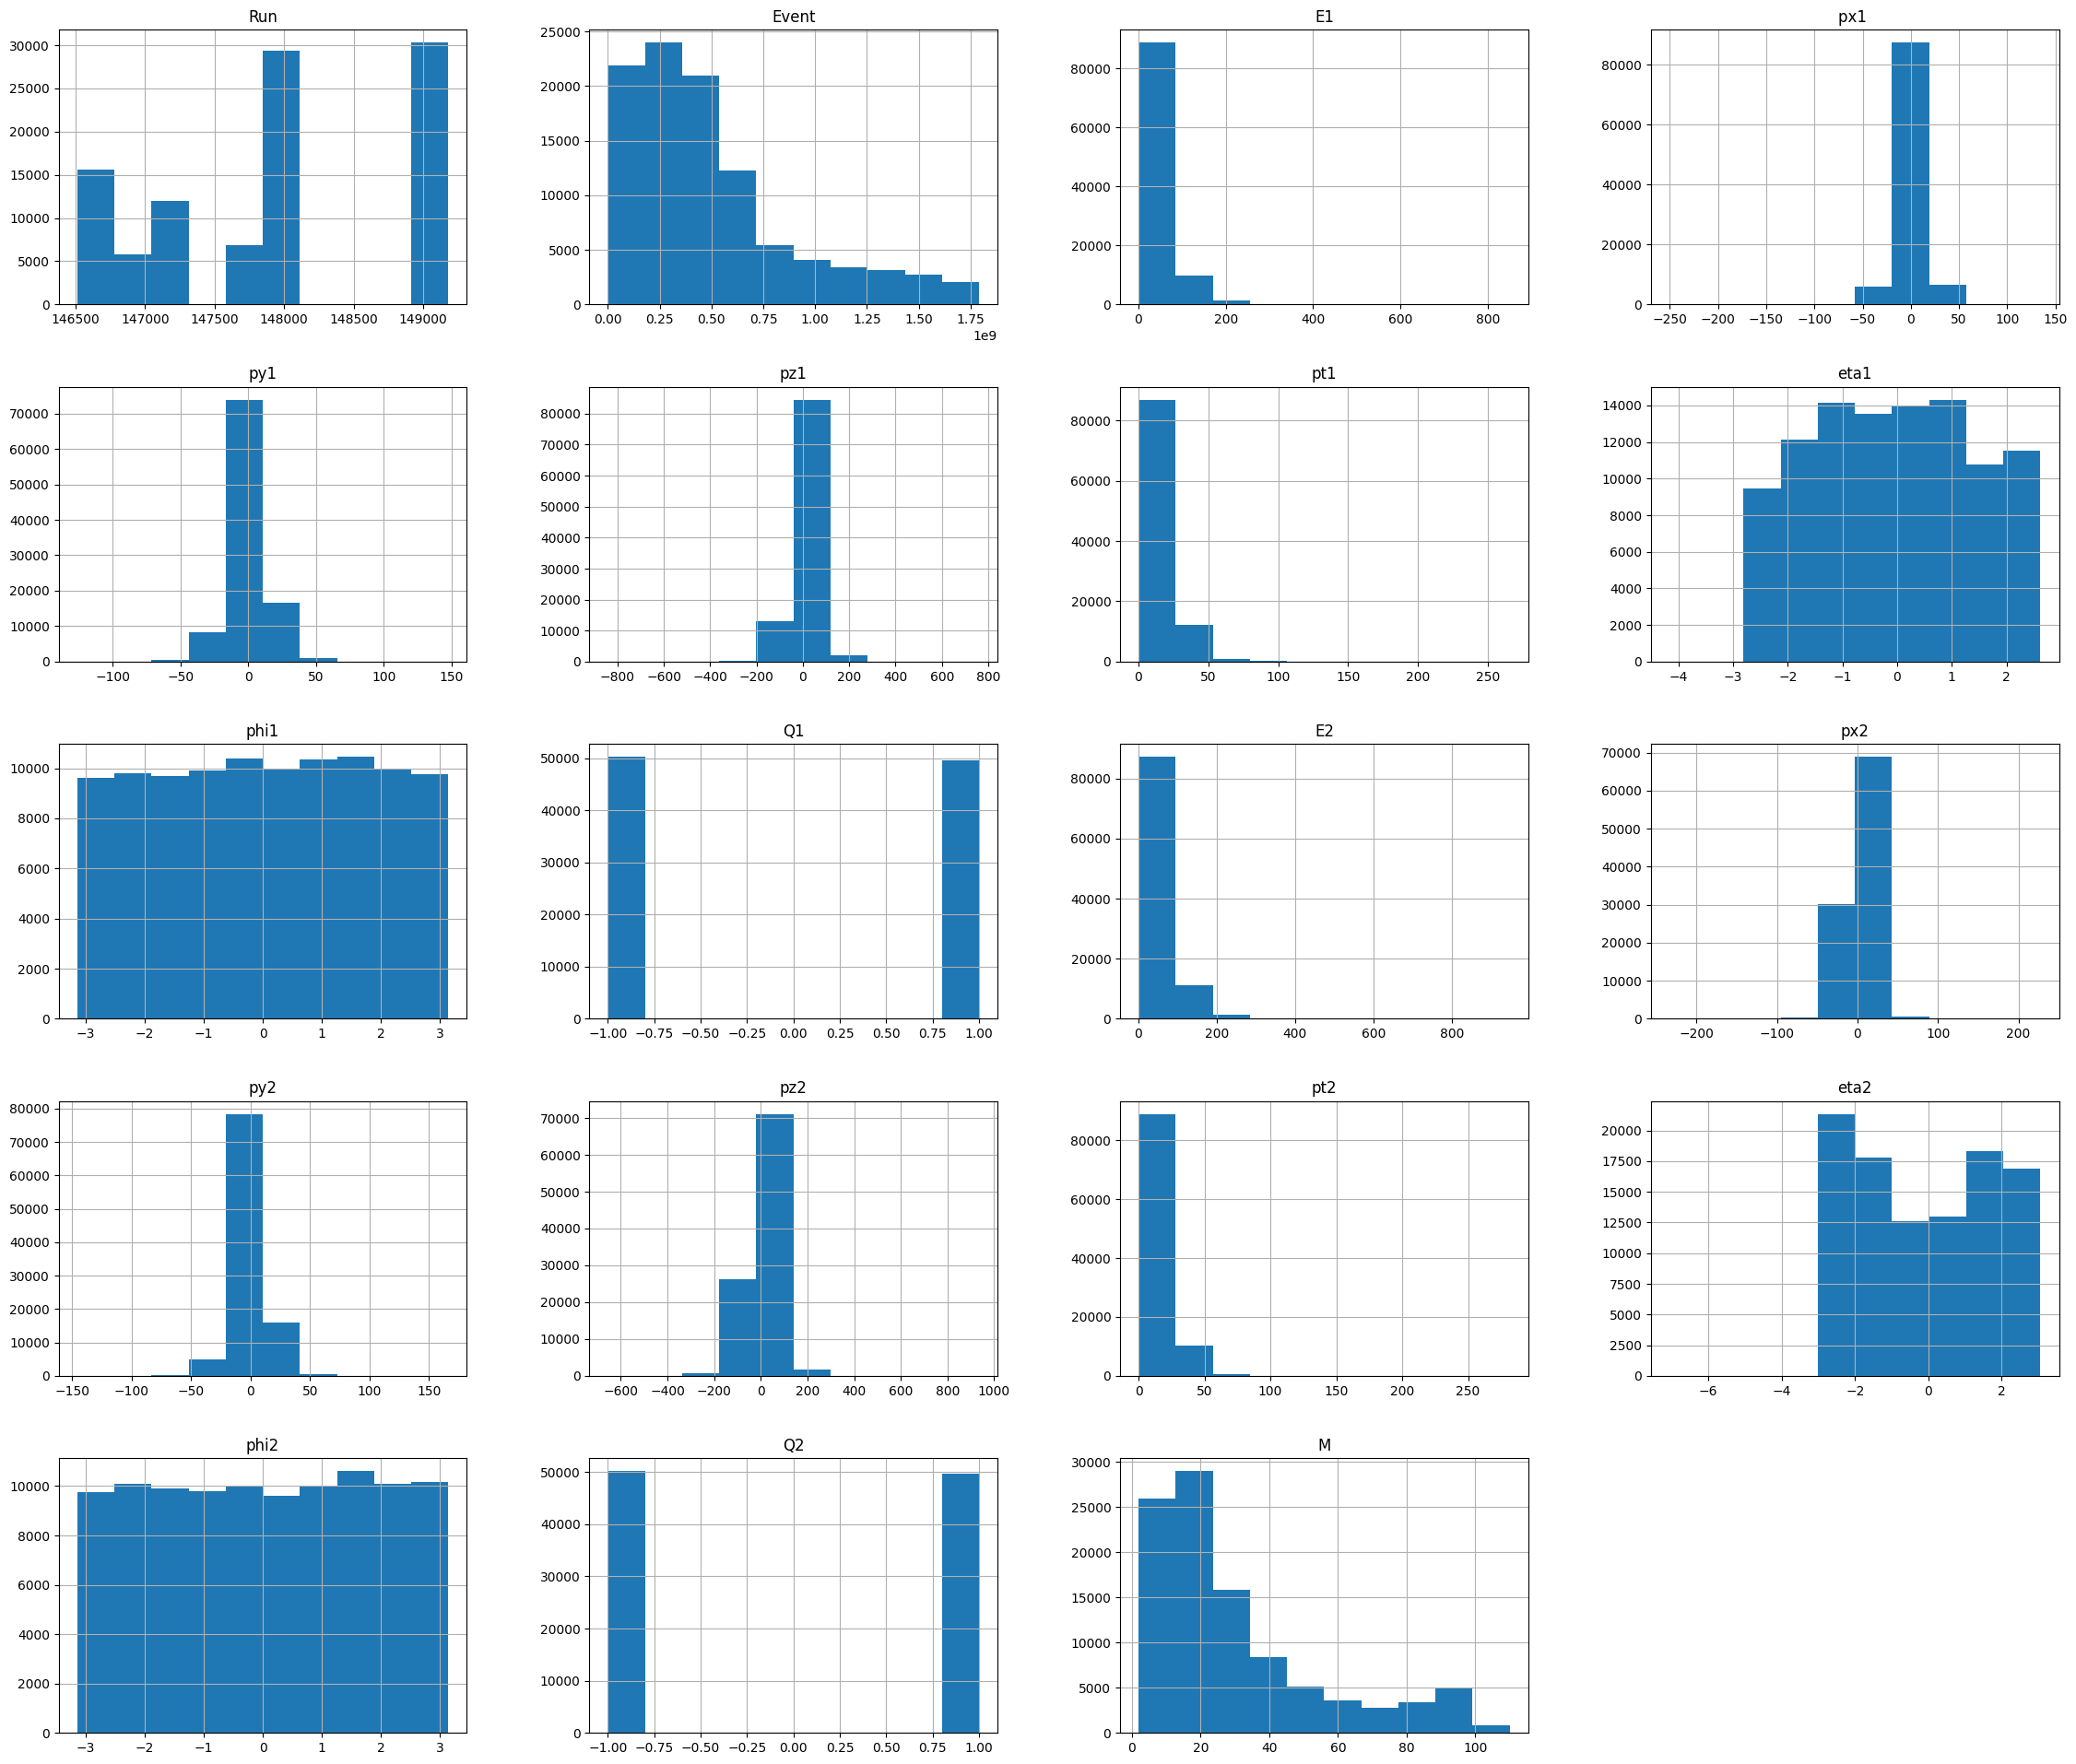

In [154]:
data.iloc[:,:].hist(figsize=(28,24))
plt.show()

**The Run column and the Event column are not necesssary for the evaluation of the invariant mass.**

Thus, we drop these columns 

In [155]:
data = data.drop(['Run','Event'], axis=1)
data.shape

(99891, 17)

### Split the data into features and target set
- X: feature set containing 16 features
- y: target set containing 1 column, invariant mass M

In [156]:
y = data['M']
X = data.drop(columns = ['M'])

In [157]:
X.head()
X.shape

(99891, 16)

## 4. Splitting the dataset into train and test sets

In [158]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8, random_state=69)
print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: (99891, 16)
y shape: (99891,)


## 5. Bulding the XGB model before feature engineering

In [159]:
import xgboost
from xgboost import XGBRegressor

In [160]:
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
print(f"MSE:{mse(y_pred,y_train)}")
print(f"MAE:{mae(y_pred,y_train)}")

MSE:10.075497270149897
MAE:2.368201434540632


In [161]:
y_pred = model.predict(X_test)
print(f"MSE test:{mse(y_pred,y_test)}")
print(f"MAE test:{mae(y_pred,y_test)}")

MSE test:16.055877169063315
MAE test:2.823592084062372


**We can see here the squared error is quite high for both train and test sets**

Thus, we need to implement feature engineering to get better results
## 6. Feature Engineering

**New Additional Features:**
1. Q12 = Q1 * Q2
2. pt12 = pt1 * pt2
3. E12 = E1 * E2
4. E = E1 + E2

<Axes: >

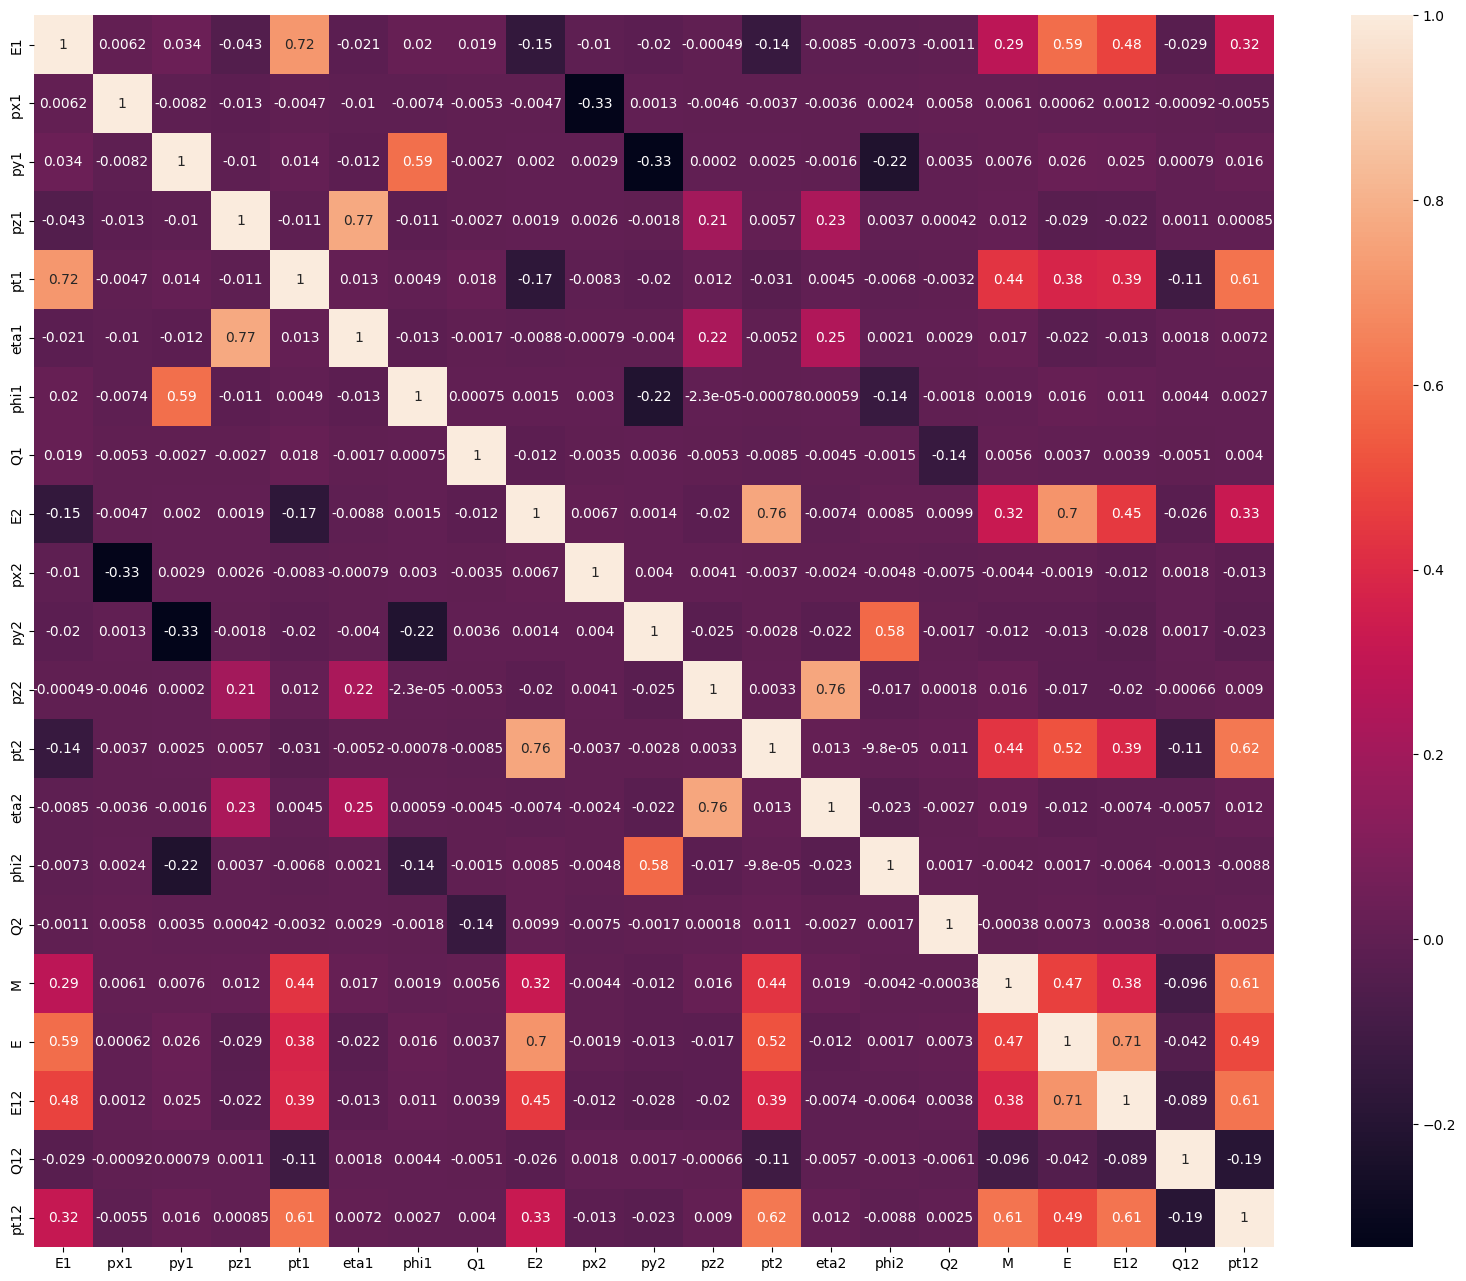

In [162]:
data['E'] = data.E1 + data.E2
data['E12'] = data.E1 * data.E2
data['Q12'] = data.Q1 * data.Q2
data['pt12'] = data.pt1 * data.pt2
data.head()
plt.figure(figsize=(20,16))
sns.heatmap(data.corr(),annot=True)

In [163]:
X['E'] = X.E1 + X.E2
X['E12'] = X.E1 * X.E2
X['Q12'] = X.Q1 * X.Q2
X['pt12'] = X.pt1 * X.pt2
X.head()

,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,E,E12,Q12,pt12
0,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,69.99770,662.506419,-1,27.504072
1,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,23.76108,113.388452,-1,53.468448
2,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,41.36220,404.080521,1,31.445869
3,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,90.52320,1643.222398,-1,68.097844
4,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,75.33750,853.367850,1,36.421307


We can now see the correlation map with better results.
These products seem to increase correlation with out target invariant mass (M)

In [164]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8, random_state=69)
print(f"X shape: {X.shape}\ny shape: {y.shape}")

model = XGBRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
print(f"MSE:{mse(y_pred,y_train)}")
print(f"MAE:{mae(y_pred,y_train)}")

X shape: (99891, 20)
y shape: (99891,)
MSE:6.6090727591744765
MAE:1.9052833080798364


In [165]:
y_pred = model.predict(X_test)
print(f"MSE test:{mse(y_pred,y_test)}")
print(f"MAE test:{mae(y_pred,y_test)}")

MSE test:11.31370092357257
MAE test:2.256285029719099


The error has decreased after introducing new features through feature engineering.

**But, can we make our model more efficient? Let's try.** 

### New Additional Features:
1. Q12 = Q1 * Q2
2. pt12 = pt1 * pt2
3. E12 = E1 * E2
4. E = E1 + E2
5. px12 = px1 * px2
6. py12 = py1 * py2
7. pz12 = pz1 * pz2
8. phi12 = phi1 * phi2
9. eta12 = eta1 * eta2

In [166]:
data.columns

Index(['E1', 'px1 ', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1', 'E2', 'px2',
       'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'M', 'E', 'E12', 'Q12',
       'pt12'],
      dtype='object')

<Axes: >

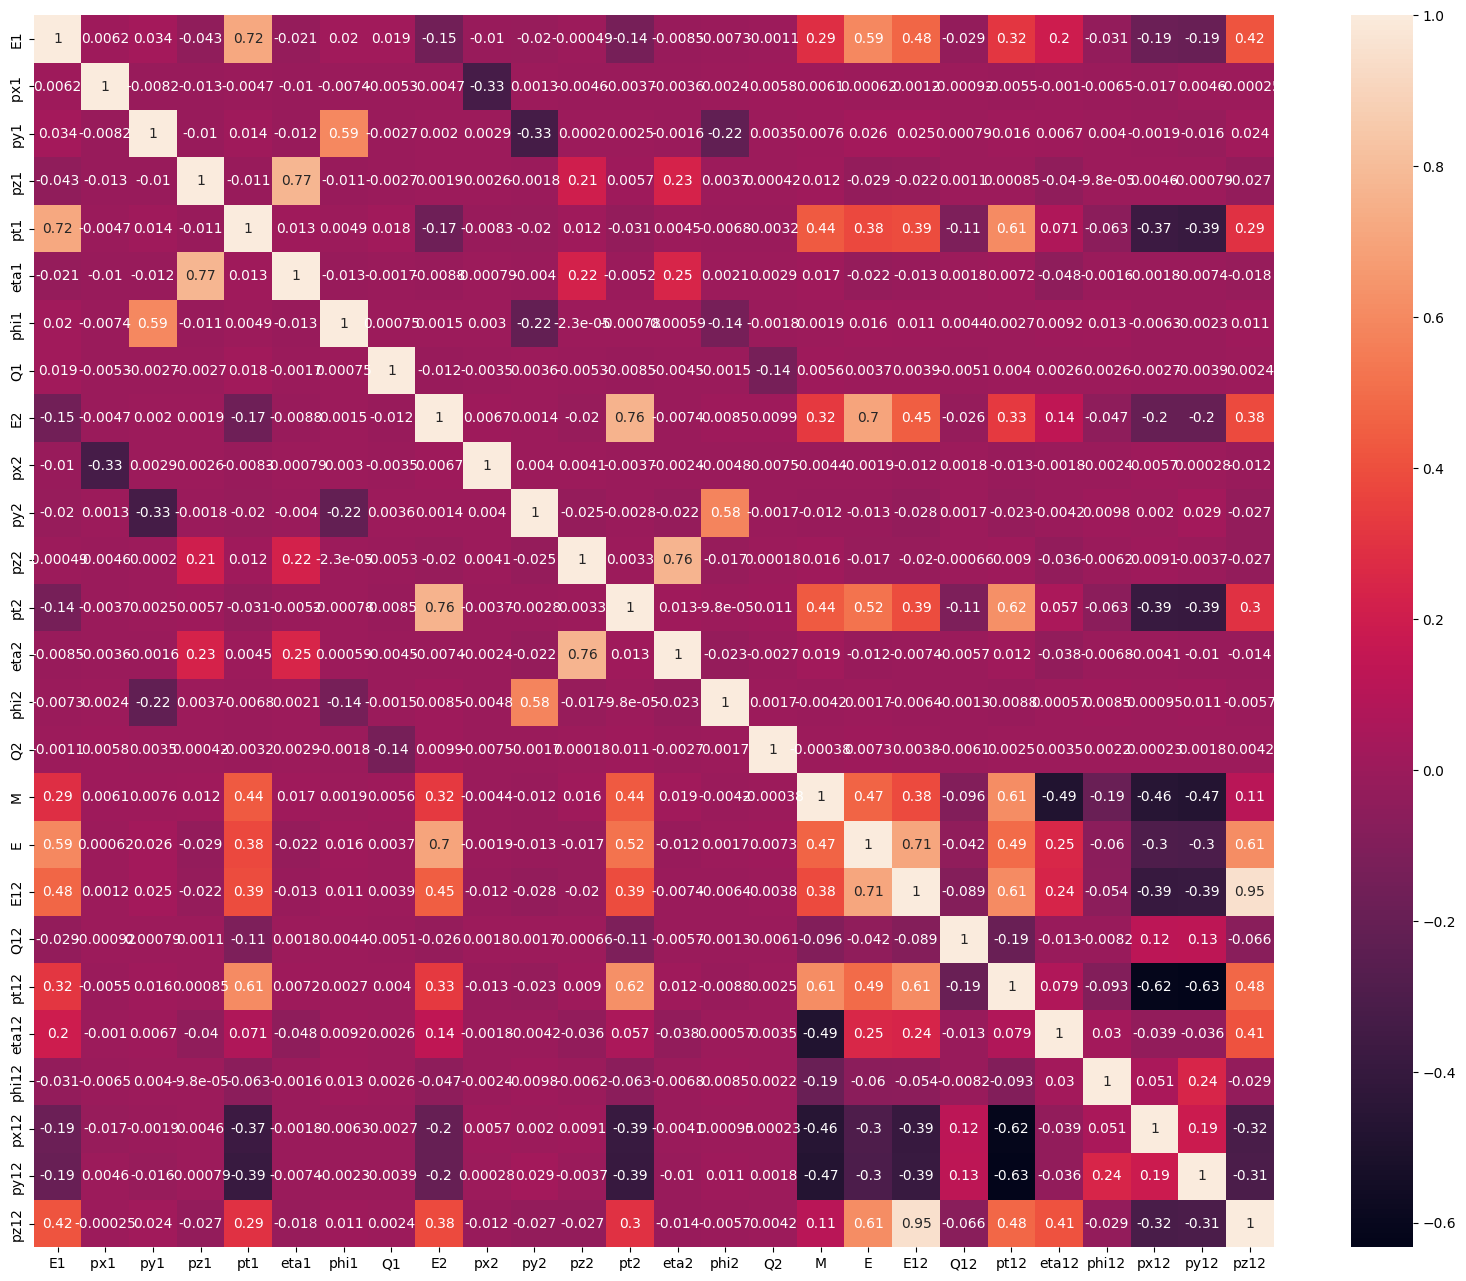

In [167]:
# data['E'] = data.E1 + data.E2
data['eta12'] = data.eta1 * data.eta2
data['phi12'] = data.phi1 * data.phi2
data['px12'] = data['px1 '] * data.px2
data['py12'] = data.py1 * data.py2
data['pz12'] = data.pz1 * data.pz2

data.head()
plt.figure(figsize=(20,16))
sns.heatmap(data.corr(),annot=True)

In [168]:
X['eta12'] = X.eta1 * X.eta2
X['phi12'] = X.phi1 * X.phi2
X['px12'] = X['px1 '] * X.px2
X['py12'] = X.py1 * X.py2
X['pz12'] = X.pz1 * X.pz2
X_new = X
X_new.head()

,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,...,Q2,E,E12,Q12,pt12,eta12,phi12,px12,py12,pz12
0,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,...,-1,69.99770,662.506419,-1,27.504072,5.163125,-4.513875,7.547768,-19.805230,634.729138
1,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,...,1,23.76108,113.388452,-1,53.468448,-0.831043,-8.212527,48.635975,-2.925218,-58.616489
2,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,...,1,41.36220,404.080521,1,31.445869,-3.487392,6.371799,16.909070,4.612053,-354.249244
3,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,...,-1,90.52320,1643.222398,-1,68.097844,5.169291,0.569945,30.708577,30.863785,1574.704187
4,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,...,-1,75.33750,853.367850,1,36.421307,5.074622,2.310784,-0.820172,35.468821,814.945097


In [169]:
# X_train,X_test,y_train_y_test = train_test_split(X_new,y,train_size=0.8, random_state=69)
X_train,X_test,y_train,y_test = train_test_split(X_new,y,train_size=0.8, random_state=69)
print(f"X_new shape: {X.shape}\ny shape: {y.shape}")

model_new = XGBRegressor()
model_new.fit(X_train,y_train)
y_pred = model_new.predict(X_train)
print("\nAfter feature engineering, i.e., adding new features")
print(f"MSE:{mse(y_pred,y_train)}")
print(f"MAE:{mae(y_pred,y_train)}")

X_new shape: (99891, 25)
y shape: (99891,)

After feature engineering, i.e., adding new features
MSE:0.9330368060011726
MAE:0.6824682484530934


### Feature engineering has reduced the error values which is quite good enough for our use case. 